# Estimating how many homeless people would be impacted

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

Data from the Los Angeles Homeless Service Authority. These are the result of its [2019 count at the tract level](https://www.lahsa.org/documents?id=3493-homeless-count-2019-results-by-census-tract.xlsx) for the entire county, except for three cities that conduct their own counts (Long Beach, Glendale and Pasadena).

In [2]:
hlcount = pd.read_excel(
    'input/homelesscount/homeless-count-2019-results-by-census-tract.xlsx',
    sheet_name='Counts_by_Tract',
    dtype={'tract':str}
)

In [3]:
hlcount.head()

,tract,Year,City,LACity,Community_Name,SPA,SD,CD,DemogSurvCt,YouthSurvCt,...,totSHYouthSingYouth,totSHYouthFamHH,totSHYouthFamMem,totSHYouthUnaccYouth,totUnsheltPeople,totESPeople,totTHPeople,totSHPeople,totSheltPeople,totPeople
0,101110,2019,Los Angeles,1,Tujunga,2,5,7,0,1,...,0,0,0,0,12.614,0,0.0,0,0,12.614
1,101122,2019,Los Angeles,1,Tujunga,2,5,7,0,0,...,0,0,0,0,1.000,0,0.0,0,0,1.000
2,101210,2019,Los Angeles,1,Tujunga,2,5,7,0,0,...,0,0,0,0,14.517,0,0.0,0,0,14.517
3,101220,2019,Los Angeles,1,Tujunga,2,5,7,0,0,...,0,0,0,0,24.058,0,0.0,0,0,24.058
4,101300,2019,Los Angeles,1,Tujunga,2,5,7,0,0,...,0,0,0,0,9.278,0,0.0,0,0,9.278


In [4]:
len(hlcount)

2163

**To gauge the impact of the analysis, we need to focus on the population of homeless people estimated to sleep outside and *not* those in cars, vans or other vehicles. We'll tabulate both the total unsheltered population and the subset presumed to be sleeping outside.**

In [5]:
hlcount['totOutsidePeople'] = \
hlcount.totStreetSingAdult + hlcount.totTentPeople + hlcount.totMakeshiftPeople

In [6]:
hlcounttrimmed = hlcount[['tract','totUnsheltPeople','totOutsidePeople']]

In [7]:
hlcounttrimmed.head()

,tract,totUnsheltPeople,totOutsidePeople
0,101110,12.614,1.000
1,101122,1.000,1.000
2,101210,14.517,6.047
3,101220,24.058,6.196
4,101300,9.278,4.196


Get our "apportioned" tracts

In [8]:
tracthood = pd.read_csv('input/neighborhoods/tract-neighborhood-allocation.csv', dtype={'tract':str})

In [9]:
tracthood['tract'] = tracthood['tract'].str.slice(start=-6)

In [10]:
tracthood.head()

,tract,name,tract_percent
0,101110,Tujunga,1.000000
1,101122,Sunland,0.003235
2,101122,Tujunga,0.996765
3,101210,Tujunga,1.000000
4,101220,Tujunga,1.000000


In [11]:
len(tracthood)

2023

Merge the two data sets

In [12]:
merged = pd.merge(
    hlcounttrimmed,
    tracthood
)

In [13]:
merged.head()

,tract,totUnsheltPeople,totOutsidePeople,name,tract_percent
0,101110,12.614,1.000,Tujunga,1.000000
1,101122,1.000,1.000,Sunland,0.003235
2,101122,1.000,1.000,Tujunga,0.996765
3,101210,14.517,6.047,Tujunga,1.000000
4,101220,24.058,6.196,Tujunga,1.000000


In [14]:
len(merged)

1995

Use the multiplier to split up the populations into their neighborhoods

In [15]:
merged['totUnsheltPeoplePortion'] = merged['totUnsheltPeople'] * merged['tract_percent']
merged['totOutsidePeoplePortion'] = merged['totOutsidePeople'] * merged['tract_percent']

In [16]:
merged.head()

,tract,totUnsheltPeople,totOutsidePeople,name,tract_percent,totUnsheltPeoplePortion,totOutsidePeoplePortion
0,101110,12.614,1.000,Tujunga,1.000000,12.614000,1.000000
1,101122,1.000,1.000,Sunland,0.003235,0.003235,0.003235
2,101122,1.000,1.000,Tujunga,0.996765,0.996765,0.996765
3,101210,14.517,6.047,Tujunga,1.000000,14.517000,6.047000
4,101220,24.058,6.196,Tujunga,1.000000,24.058000,6.196000


Aggregate up by neighborhood

In [17]:
totalsbyhood = merged.groupby('name')\
[['totUnsheltPeoplePortion','totOutsidePeoplePortion']]\
.sum()\
.reset_index()\
.sort_values('totOutsidePeoplePortion', ascending=False)

In [18]:
len(totalsbyhood)

115

In [19]:
totalsbyhood.columns = ['name','unsheltered','unshelteredoutside']

**What neighborhoods have the most and least homeless people sleeping outside?**

In [20]:
totalsbyhood.sort_values('unshelteredoutside', ascending=False).head(10)

,name,unsheltered,unshelteredoutside
23,Downtown,2477.656050,2298.862691
86,Skid Row,1560.699515,1511.234336
109,Westlake,1239.655588,921.219987
46,Historic South-Central,944.710611,673.731808
47,Hollywood,1191.539096,634.890246
99,Venice,1091.534800,567.493195
9,Boyle Heights,869.935630,512.306282
52,Koreatown,568.309486,440.784516
25,East Hollywood,528.656377,362.502867
98,Van Nuys,675.235038,327.020823


In [21]:
totalsbyhood.sort_values('unshelteredoutside', ascending=False).tail(10)

,name,unsheltered,unshelteredoutside
29,Elysian Valley,65.166004,6.713450
53,Lake Balboa,23.329680,6.488715
49,Hollywood Hills West,6.521895,5.432202
8,Beverlywood,11.621459,5.298418
15,Century City,6.952370,3.265168
55,Larchmont,3.229615,3.129461
17,Chatsworth Reservoir,0.756257,0.176586
77,Porter Ranch,142.443669,0.125707
6,Beverly Crest,0.082356,0.066498
5,Bel-Air,0.072950,0.058907


**How many homeless people in the city are unsheltered?**

In [22]:
totalsbyhood.unsheltered.sum()

26354.024848290926

**How many homeless people in the city are unsheltered and living outside (not in cars, vehicles, etc.)?**

In [23]:
totalsbyhood.unshelteredoutside.sum()

15400.081918445705

In [24]:
totalsbyhood.to_csv('output/counts/homeless-unsheltered-by-hood.csv', index=False)

Combine with buffer stats

In [25]:
buffers = pd.read_csv('output/buffers/buffers-by-hood-breakdown.csv')

In [26]:
buffers.head()

,name,hood_area,buffer_area,pct_of_hood_in_buffer
0,Cypress Park,0.726685,0.454308,0.625178
1,Westlake,2.717338,1.692640,0.622904
2,Watts,2.121397,1.248720,0.588631
3,Koreatown,2.704202,1.562684,0.577872
4,Pico-Union,1.670386,0.944300,0.565318


In [27]:
len(buffers)

115

In [28]:
joined = pd.merge(totalsbyhood, buffers)

In [29]:
joined.head()

,name,unsheltered,unshelteredoutside,hood_area,buffer_area,pct_of_hood_in_buffer
0,Downtown,2477.656050,2298.862691,5.435817,1.603251,0.294942
1,Skid Row,1560.699515,1511.234336,0.399047,0.185527,0.464925
2,Westlake,1239.655588,921.219987,2.717338,1.692640,0.622904
3,Historic South-Central,944.710611,673.731808,2.555178,1.343640,0.525850
4,Hollywood,1191.539096,634.890246,3.502332,1.749808,0.499612


In [30]:
len(joined)

115

Some plots to visualize the trends

Text(0.5, 1.0, 'All homeless')

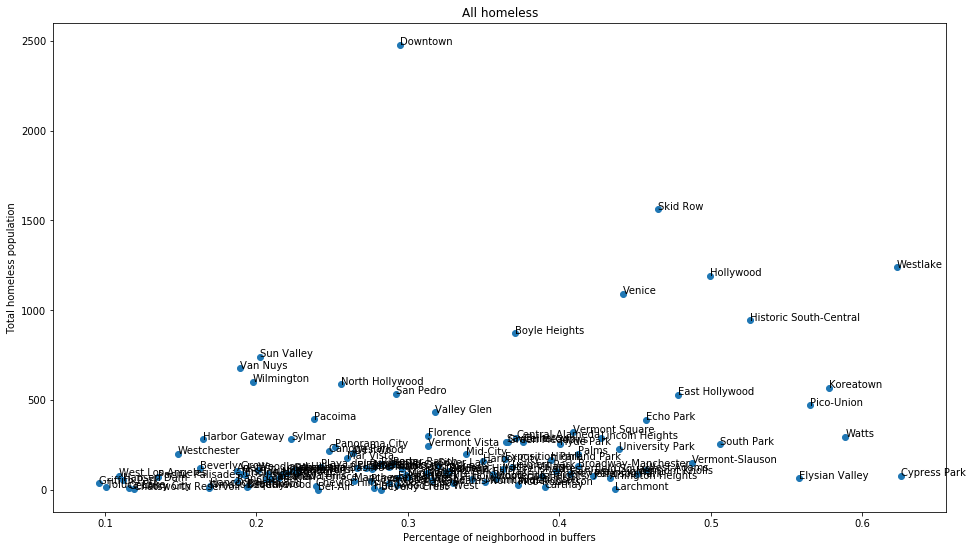

In [31]:
plt.figure(figsize=(16,9))
plt.scatter(joined['pct_of_hood_in_buffer'], joined['unsheltered'])
for i, txt in enumerate(joined['name']):
    plt.annotate(txt, (joined['pct_of_hood_in_buffer'].iloc[i], joined['unsheltered'].iloc[i]))
plt.ylabel('Total homeless population')
plt.xlabel('Percentage of neighborhood in buffers')
plt.title('All homeless')

Text(0.5, 1.0, 'Homeless sleeping outside')

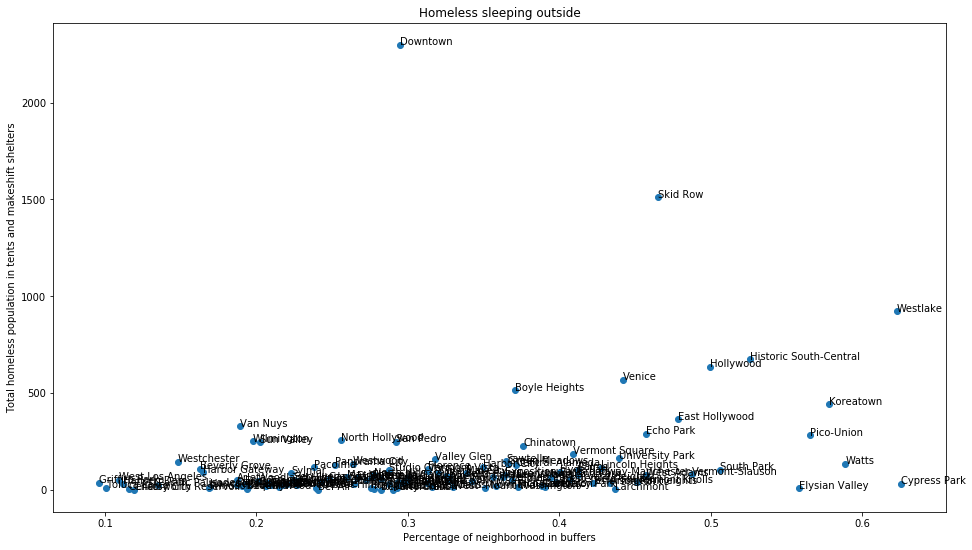

In [32]:
plt.figure(figsize=(16,9))
plt.scatter(joined['pct_of_hood_in_buffer'], joined['unshelteredoutside'])
for i, txt in enumerate(joined['name']):
    plt.annotate(txt, (joined['pct_of_hood_in_buffer'].iloc[i], joined['unshelteredoutside'].iloc[i]))
plt.ylabel('Total homeless population in tents and makeshift shelters')
plt.xlabel('Percentage of neighborhood in buffers')
plt.title('Homeless sleeping outside')

In [33]:
joined.to_csv('output/joined-buffers-homeless-stats.csv', index=False)